# Templatematching Validation
- Problem: Punkte sehr eng entlang Scanlinien, aber Scanlinien weit auseinander
- RMSE wird nur auf den Inliern berechnet
- hängt von threshold und dem Abstand der Scanlinien ab!
- Daher: Eigenen Validierer


Erster Versuch 
- Idee war
    - Cluster auf die Länge des Templates croppen
    - für jeden Punkt im Cluster Entfernung zum nächsten Punkt im Template
    - mit kleinem Threshold (0.005) inlier und outlier
    - ratio inlier / total
    - rmse inlier
    - rmse alle 


In [324]:
import pdal 
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import KDTree, cKDTree
from scipy.linalg import svd 
from osgeo import ogr
import pyvista as pv
import os
import json
import time 
import matplotlib.pyplot as plt
import copy

import open3d as o3d
from interessant import * # Bei Änderungen Kernel neu starten


ogr.UseExceptions()

In [325]:
gauge = 1.435
railhead_width = 0.067

In [326]:
def pca(cloud):
    """Use PCA to get einvalues and eigenvectors of a point cloud
    
    Returns (eigenvalues, eigenvectors)
    """
    if cloud.shape[0] < 3:
        raise ValueError("Point cloud must have at least 3 points")
    mean = np.mean(cloud, axis=0)
    centered = cloud - mean
    U, S, Vt = svd(centered, full_matrices=False)
    eigenvals = S**2/(cloud.shape[0]-1)
    # Returned vectors are in columns, first vector is eigenvec[:, 0] == eigenvec.T[0]
    return eigenvals, Vt.T

In [ ]:
def plot_cluster(cluster, eigenvects=None): 
    center = cluster.mean(axis=0)
    centered = cluster - center

    if eigenvects is None:
        eigenvals, eigenvects = pca(cluster)

    transformed = centered @ eigenvects
    fig, ax = plt.subplots(figsize=(10, 15))
    ax.scatter(transformed[:,0], transformed[:,2], c=transformed[:,1], cmap=plt.cm.plasma, marker=".")
    ax.set_aspect("equal")
    plt.show()
    return fig, ax

In [327]:
def get_central_point(a, b):
    """Get the point in the middle of two points"""
    vector = b - a
    return a + vector / 2

In [328]:
def plot_cluster(cluster, eigenvects=None): 
    center = cluster.mean(axis=0)
    centered = cluster - center

    if eigenvects is None:
        eigenvals, eigenvects = pca(cluster)

    transformed = centered @ eigenvects
    fig, ax = plt.subplots(figsize=(10, 15))
    ax.scatter(transformed[:,0], transformed[:,2], c=transformed[:,1], cmap=plt.cm.plasma, marker=".")
    ax.set_aspect("equal")
    plt.show()
    return fig, ax
    

In [329]:
def plot_cluster_pair(cluster, cluster_other, transformmatrix, percentile=95, railhead_width = 0.067, centering="cluster"): 
    """Plot pair of clusters in the PCA coordinate system of the pair 
    
    Args:
        cluster (np.array): Cluster of points
        cluster_other (np.array): Other cluster of points
        eigenvects (np.array): Eigenvectors of the PCA of the pair of clusters
        percentile (int): Percentile of the height for the horizontal line
        railhead_width (float): Width of the railhead (0.067 or 0.072)
        centering (str): "cluster" or "pair"
    """
    center = (cluster.sum(axis=0) + cluster_other.sum(axis=0)) / (cluster.shape[0] + cluster_other.shape[0])
    center_cluster = cluster.mean(axis=0)
    center_other = cluster_other.mean(axis=0)

    if centering == "cluster":
        cluster = cluster - center_cluster
        cluster_other = cluster_other - center_other
    else:
        cluster = cluster - center
        cluster_other = cluster_other - center

    transformed = cluster @ transformmatrix
    transformed_other = cluster_other @ transformmatrix
    #print("center", center)
    #print(center_cluster - center, center_other - center)
    #print((center_cluster - center) @ transformmatrix, (center_other - center) @ transformmatrix)


    # Check if we need to switch the left, right cluster
    center_cluster_in_pc = (center_cluster - center) @ transformmatrix
    center_other_in_pc = (center_other - center) @ transformmatrix
    if center_cluster_in_pc[0] > center_other_in_pc[0]:
        transformed, transformed_other = transformed_other, transformed
        #print("Switched clusters")

    fig, ax = plt.subplots(1,2, figsize=(15, 7))

    if centering == "cluster":
        ax[0].set_ylim(-0.08, 0.06)
        ax[1].set_ylim(-0.08, 0.06)
    else:
        ax[0].set_xlim(-0.85, -0.65)
        ax[0].set_ylim(-0.08, 0.06)
        ax[1].set_xlim(0.65, 0.85)
        ax[1].set_ylim(-0.08, 0.06)
        ax[0].axvline(-gauge/2, color="lightgrey", linestyle="-", zorder=-1)
        ax[0].axvline(-gauge/2 - railhead_width, color="lightgrey", linestyle="-", zorder=-1)
        ax[1].axvline(gauge/2, color="lightgrey", linestyle="-", zorder=-1)
        ax[1].axvline(gauge/2 + railhead_width, color="lightgrey", linestyle="-", zorder=-1)

    ax[0].scatter(transformed[:,0], transformed[:,2], c=transformed[:,1], cmap=plt.cm.plasma, marker=".")
    ax[0].set_aspect("equal")

    x_mean = transformed[:,0].mean()
    ax[0].axvline(x_mean, color="forestgreen", linestyle="--", zorder=-1)
    ax[0].axvline(x_mean - (railhead_width/2), color="lightgreen", linestyle="--", zorder=-1)
    ax[0].axvline(x_mean + (railhead_width/2), color="lightgreen", linestyle="--", zorder=-1)
    ax[0].axhline(np.percentile(transformed[:,2], percentile), color="forestgreen", linestyle="--", zorder=-1)
    ax[0].axhline(transformed[:,2].mean(), color="forestgreen", linestyle="--", zorder=-1)

    ax[1].scatter(transformed_other[:,0], transformed_other[:,2], c=transformed_other[:,1], cmap=plt.cm.plasma, marker=".")
    ax[1].set_aspect("equal")

    x_mean = transformed_other[:,0].mean()
    ax[1].axvline(x_mean, color="forestgreen", linestyle="--", zorder=-1)
    ax[1].axvline(x_mean - (railhead_width/2), color="lightgreen", linestyle="--", zorder=-1)
    ax[1].axvline(x_mean + (railhead_width/2), color="lightgreen", linestyle="--", zorder=-1)
    ax[1].axhline(np.percentile(transformed_other[:,2], percentile), color="forestgreen", linestyle="--", zorder=-1)
    ax[1].axhline(transformed_other[:,2].mean(), color="forestgreen", linestyle="--", zorder=-1)

    plt.show()
    return fig, ax, transformed, transformed_other




In [330]:
def which_side(cluster):
    """Check which on which side of the rail the transformed cluster is
    
    Returns a value between -1 and 1, positive values if points are on the 
    right side of the rail, and negative values for the left side. 
    The absolute value is kind of the confidence of the estimation.
    """

    # Count the points below the centroid, on the left and the right side 
    # but only within half the width of the railhead 

    left_mask = (cluster[:,2] < 0) & (cluster[:,0] < 0) & (cluster[:,0] > -railhead_width/2)
    right_mask = (cluster[:,2] < 0) & (cluster[:,0] > 0) & (cluster[:,0] < railhead_width/2)
    left_count = np.sum(left_mask)
    right_count = np.sum(right_mask)
    both_count = left_count + right_count
    if both_count == 0:
        return 0
    return (left_count - right_count) / both_count

In [331]:
def representive_point_3(cluster, transformmatrix, upperpercentile=90, lowerpercentile=70, railhead_width=0.067, side=None):
    """Version 3

    Unterschied bei "Vor allem Top": 
        min und max x bei z>-0.01
        lowerpercentile des oberen Teils für z
    """


    center = cluster.mean(axis=0)
    centered = cluster - center
    transformed = centered @ transformmatrix
    max_z = transformed[:,2].max()

    if max_z < 0.03:
        # This happens if most points are on the top of the rail (usually max_z close to 0.02)
        # Calculate the mean of the range for points above -0.01
        # (this makes sure we get the approx. railhead width)
        transformed_x_upper = transformed[transformed[:,2] > -0.01][:,0]
        center_x = (transformed_x_upper.max() + transformed_x_upper.min()) / 2
        # only consider points above the centroid
        center_z = np.percentile(transformed[transformed[:,2] > 0][:,2], lowerpercentile)
        side = 0
    else:
        # Many points are on the side of the rail (usually the max_z around 0.04)
        # but we need check which side 

        if side is None:
            side = which_side(transformed)

        # x values of points above the centroid
        # (there might be outliers in the lower part of the cluster)
        transformed_x_upper = transformed[transformed[:,2] > 0][:,0]

        if side < 0:
            # left side
            # Only consider one quadrant in the transformed space
            # This makes clusters with more or less points on the rail top more comparable
            min_x = np.percentile(transformed_x_upper[transformed_x_upper < 0],100-lowerpercentile)
            center_x = min_x + railhead_width / 2
        else:
            max_x = np.percentile(transformed_x_upper[transformed_x_upper > 0],lowerpercentile)
            center_x = max_x - railhead_width / 2 
        center_z = np.percentile(transformed[transformed[:,2] > 0][:,2], upperpercentile)

    
    transformed_representive = np.array([center_x, 0, center_z])
    return transformed_representive @ transformmatrix.T + center, side

In [ ]:
def get_transformmatrix(cluster, cluster_other, clustercenter, clustercenter_other, eigenvects):
    # Use the top part of the rail clusters to circumvent the problem different point distributions
    top = cluster[:,2].max()
    top_other = cluster_other[:,2].max()
    topcenter = np.array([clustercenter[0], clustercenter[1], top])
    topcenter_other = np.array([clustercenter_other[0], clustercenter_other[1], top_other])
    sidevector = topcenter - topcenter_other
    # Project on the plane perpendicular to the first eigenvector
    # (eigenvects are normalized)
    projection_on_first_eig = (sidevector @ eigenvects.T[0]) * eigenvects.T[0]
    sidevector_perpendicular = sidevector - projection_on_first_eig
    sidevector_perpendicular = sidevector_perpendicular / np.linalg.norm(sidevector_perpendicular)
    normal = np.cross(sidevector_perpendicular, eigenvects.T[0]) 

    matrix = np.array([sidevector_perpendicular, eigenvects.T[0], normal]).T

    print("determinant", np.linalg.det(matrix))

    if normal[2] < 0:
        print("Upside down")
        Rx_180 = np.array([
            [1,  0,           0],
            [0, -1,           0],
            [0,  0,          -1]
        ])
        # Data in row vector, this is first the main rotation, than the rotation around the y axis
        matrix = matrix @ Rx_180 
        print("determinant after", np.linalg.det(matrix))

    return matrix

In [333]:
def draw_registration_result(source, target, transformation):
    axes = axes = o3d.geometry.TriangleMesh().create_coordinate_frame(size=0.1)
    source_temp = copy.deepcopy(source)
    target_temp = copy.deepcopy(target)
    source_temp.paint_uniform_color([1, 0.706, 0])
    target_temp.paint_uniform_color([0, 0.651, 0.929])
    source_temp.transform(transformation)
    o3d.visualization.draw_geometries([source_temp, target_temp, axes])


In [334]:
def load_clusters(preset):
    fileleft = f"clusterbeispiele/{preset}_l.ply"
    fileright = f"clusterbeispiele/{preset}_r.ply"
    filepair = f"clusterbeispiele/{preset}_pair.ply"
    if not os.path.exists(fileleft):
        raise FileNotFoundError(f"File {fileleft} not found")
    cluster = o3d.io.read_point_cloud(fileleft)
    cluster_other = o3d.io.read_point_cloud(fileright)
    cluster_pair = o3d.io.read_point_cloud(filepair)
    return np.asarray(cluster.points) , np.asarray(cluster_other.points), np.asarray(cluster_pair.points)

In [ ]:
def get_o3d_transform(eigenvects, translation=None):
    """Create an open3d 4x4 transformation matrix from eigenvectors
    
    Version für 2 Schienen
    """
    eigenvects = eigenvects.copy()

    # Check if the last eigenvector is pointing down
    if eigenvects[2,2] < 0: # z of last eigenvector is negative
        print("o3d trans was Upside down")
        # reflect
        eigenvects[:,2] *= -1 # reflection 

    # There is a 50% chance that det(eigenvects) is close to -1
    # (then the matrix includes a reflection)
    if np.linalg.det(eigenvects) < 0:
        # flip the first eigenvector
        eigenvects[:,0] *= -1


    transform = np.eye(4)
    transform[0:3, 0:3] = eigenvects

    if translation is not None:
        transform[:3, 3] = translation
    return transform

In [336]:
templatefiles = [
    "T_profil_ähnlich_54E4.ply", 
    "T_profil_ähnlich_54E4_schräg_random2.ply",
    "T_profil_ähnlich_54E4_schräg_random_wenig_punkte.ply"
    ]

In [337]:
def get_template(filename):
    shift = (gauge + railhead_width) / 2
    pcd = o3d.io.read_point_cloud(os.path.join("templates", filename))
    left = np.asarray(pcd.points)
    right = left.copy()
    left[:,0] -= shift
    right[:,0] += shift

    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(np.vstack((left, right)))
    return pcd

In [ ]:
def validate_registration(source, target, transformation,threshold=0.01, draw=False, crop=True, inverted=False, window_name="Validation"):
    """Validate the registration
    
    Source = the template
    Target = the point cloud of the cluster
    """
    source = copy.deepcopy(source)
    target = copy.deepcopy(target)
    source.transform(transformation)

    if inverted:
        # Template is target, point cloud the source
        target, source = source, target

    if crop:
        # Crop the target point cloud to the length of the template
        bbox = source.get_oriented_bounding_box()

        # make sure we only crop in the y direction of the oriented bounding box
        # x is the direction from left to right rail
        bbox_extent = np.array(bbox.extent) 
        bbox_extent[0] = 10
        bbox_extent[2] = 10

        bbox = o3d.geometry.OrientedBoundingBox(center=bbox.center, R=bbox.R, extent=bbox_extent)
        target = target.crop(bbox)

    total = len(target.points)

    if total == 0:
        if draw:
            target.paint_uniform_color([1, 0, 0])
            source.paint_uniform_color([1, 0.706, 0])
            axes = axes = o3d.geometry.TriangleMesh().create_coordinate_frame(size=0.1)
            o3d.visualization.draw_geometries([source, target, axes], window_name=window_name)
        return {
            "total": 0,
            "inliers": 0,
            "inlier_ratio": 0,
            "rmse_inliers": 0,
            "rmse_all": 0,
            "max_z_diff": 0,
        }

    # For each point of the cropped cluster, find the nearest point in the template
    # and check if it is within the threshold
    tree = cKDTree(np.asarray(source.points)) 
    neighbors = tree.query(np.asarray(target.points), k=1)
    dist = neighbors[0]
    inliers = dist < threshold 
    n_inliers = inliers.sum() 

    rmse_inliers = np.sqrt((dist[inliers]**2).mean())
    rmse_all = np.sqrt((dist**2).mean())

    max_z_diff = np.abs(np.asarray(target.points)[:,2].max() - np.asarray(source.points)[:,2].max())

    if draw:
        colors = np.zeros((len(target.points), 3))
        colors[inliers] = [0, 1, 0]
        colors[~inliers] = [1, 0, 0]
        target.colors = o3d.utility.Vector3dVector(colors)
        source.paint_uniform_color([1, 0.706, 0])
        axes = axes = o3d.geometry.TriangleMesh().create_coordinate_frame(size=0.1)
        o3d.visualization.draw_geometries([source, target, axes], window_name=window_name)


    return {
        "total": int(total),
        "inliers": float(n_inliers),
        "inlier_ratio": float(n_inliers / total),
        "rmse_inliers": float(rmse_inliers),
        "rmse_all": float(rmse_all),
        "max_z_diff": float(max_z_diff),
    }


In [339]:
threshold = 0.02 #05


In [340]:
preset = "PunkteSeiteVieleAusreisser"
preset = "ObenundSeite" # In Wirklichkeit nur oben
preset = "ObenNull1"
preset = "PunkteSeite"
preset = "VieleLückeMitte"
preset = "VieleGleiseEherTop" # Übergang
preset = "VieleSchürhaken"
preset = "VieleZ" # Fast nur auf Seite, schrott


translations = [None, np.array([0, 0, 0.03])]

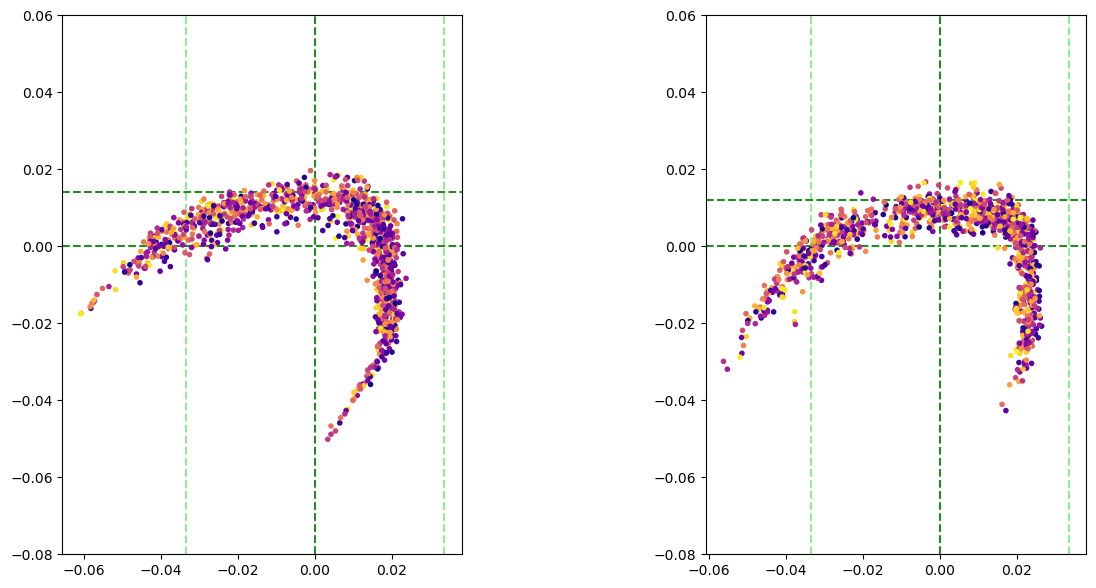

T_profil_ähnlich_54E4.ply


In [ ]:
preset = "VieleGleiseEherTop"
templatenr = 0
translation = translations[0]

templatefile = templatefiles[templatenr]

cluster_this, cluster_other, cluster_pair = load_clusters(preset)
_, eigenvects = pca(cluster_this)
plottransform = get_transformmatrix(cluster_this, cluster_other, cluster_this.mean(axis=0), cluster_other.mean(axis=0), eigenvects)
plot_cluster_pair(cluster_this, cluster_other, plottransform, percentile=95, railhead_width = 0.067, centering="cluster");

plot_cluster(cluster_pair, plottransform);
print(templatefile)

In [ ]:
_, eigenvects_pair = pca(cluster_pair)

# center = cluster_pair.mean(axis=0) # Funktioniert nicht bei Lücke 
center = get_central_point(cluster_this.mean(axis=0), cluster_other.mean(axis=0))
centered = cluster_pair - center

centered_pcd = o3d.geometry.PointCloud()
centered_pcd.points = o3d.utility.Vector3dVector(centered)


print("Translation", translation)
trans_init = get_o3d_transform(eigenvects_pair, translation)

target = centered_pcd
source = get_template(templatefile)

o3d.visualization.draw_geometries([source, target], window_name="Initial configuration (NO TRANSFORM)")


print("Evaluate initial alignment")
evaluation = o3d.pipelines.registration.evaluate_registration(
    source, target, threshold, trans_init)
print(evaluation)

# print(validate_registration(source, target, trans_init, 0.01, draw=True, window_name="Initial transformation"))


if translation is None:
    tr_string = "None"
else:
    tr_string = str(translation[2])

# draw_registration_result(source, target, trans_init)

Translation None
Evaluate initial alignment
RegistrationResult with fitness=3.379605e-01, inlier_rmse=1.181289e-02, and correspondence_set size of 5137
Access transformation to get result.


### Point to Point ICP

In [366]:
start = time.time()
print("Apply point-to-point ICP")
reg_p2p = o3d.pipelines.registration.registration_icp(
    source, target, threshold, trans_init,
    o3d.pipelines.registration.TransformationEstimationPointToPoint())
print(reg_p2p)
print("Transformation is:")
print(reg_p2p.transformation)
print("Time:", time.time() - start)
print()
# print(validate_registration(source, target, reg_p2p.transformation, 0.01, draw=True, window_name="Point-to-point ICP"))
print(f"{preset}_t{templatenr}_zTransf{tr_string}_point")

# draw_registration_result(source, target, reg_p2p.transformation)

Apply point-to-point ICP


RegistrationResult with fitness=4.413158e-01, inlier_rmse=1.027275e-02, and correspondence_set size of 6708
Access transformation to get result.
Transformation is:
[[-4.92153124e-01 -8.70507746e-01  6.92328397e-04 -5.14217219e-03]
 [-8.70508637e-01  4.92152818e-01  3.29712568e-03 -8.98602701e-03]
 [ 1.25548081e-04  1.36666446e-03  9.99994325e-01  1.23687494e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Time: 0.2355794906616211

VieleGleiseEherTop_t0_zTransfNone_point


### Point to Plane ICP

In [367]:
start = time.time()
print("Apply point-to-plane ICP")

# Point-to-plane ICP requires normals for the target
nn_distance = np.mean(target.compute_nearest_neighbor_distance())  
print("nn distance", nn_distance)  
  
#setting the radius search to compute normals  
radius_normals=nn_distance*4  
target.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=radius_normals, max_nn=16), fast_normal_computation=True)  

reg_p2l = o3d.pipelines.registration.registration_icp(
    source, target, threshold, trans_init,
    o3d.pipelines.registration.TransformationEstimationPointToPlane())
print(reg_p2l)
print("Transformation is:")
print(reg_p2l.transformation)
print("Time:", time.time() - start)
# print(validate_registration(source, target, reg_p2l.transformation, 0.01, draw=True, window_name="Point-to-plane ICP"))
print(f"{preset}_t{templatenr}_{tr_string}_plane")
# draw_registration_result(source, target, reg_p2l.transformation)

Apply point-to-plane ICP
nn distance 0.0060912556618242485
RegistrationResult with fitness=4.186184e-01, inlier_rmse=9.931162e-03, and correspondence_set size of 6363
Access transformation to get result.
Transformation is:
[[-0.49655045 -0.86799335  0.0044798  -0.00172399]
 [-0.8680061   0.49655279  0.00300551 -0.01335512]
 [ 0.00174792  0.00478278  0.99998545  0.00773285]
 [ 0.          0.          0.          1.        ]]
Time: 0.08505892753601074
VieleGleiseEherTop_t0_None_plane


## Meinen Ansatz evaluieren

In [ ]:
representive_a, side_a  = representive_point_3(cluster_this, plottransform, railhead_width=0.067) 
representive_b, side_b = representive_point_3(cluster_other, plottransform, railhead_width=0.067)

same_sides = (side_a * side_b >= 0)
print("Same sides:", same_sides)

# Check if both are classified as the same side
# but a zero and non zero value is not a problem
if side_a * side_b < 0:
    # Update the cluster with lower confidence of the side estimation
    if np.abs(side_a) < np.abs(side_b):
        representative_a, side_a  = representive_point_3(cluster_this, plottransform, railhead_width=0.067, side=side_b)
    else:
        representative_b, side_b = representive_point_3(cluster_other, plottransform,  railhead_width=0.067, side=side_a)

central_repr = get_central_point(representive_a, representive_b)
central_centroid = get_central_point(cluster_this.mean(axis=0), cluster_other.mean(axis=0))

shift = (central_repr - central_centroid)


testtransform = np.eye(4)
testtransform[0:3,0:3] = plottransform 

testtransform[0:3,3] = shift
print(testtransform)
 

print(validate_registration(source, target, testtransform, 0.01, draw=True, crop=True, window_name="ohne Transpose mit Shift"))

Same sides: True
Shift [-0.00551314 -0.00983545  0.01008649]
{'total': 2173, 'inliers': 690.0, 'inlier_ratio': 0.3175333640128854, 'rmse_inliers': 0.006592651341908567, 'rmse_all': 0.10392547850258806, 'max_z_diff': 0.01703008371960586}
[[ 0.49136607  0.87095203  0.00139431 -0.00551314]
 [ 0.87095086 -0.49136047 -0.00308071 -0.00983545]
 [ 0.00199804 -0.00272813  0.99999428  0.01008649]
 [ 0.          0.          0.          1.        ]]
{'total': 2173, 'inliers': 1039.0, 'inlier_ratio': 0.4781408191440405, 'rmse_inliers': 0.005063027318229982, 'rmse_all': 0.10359177571018659, 'max_z_diff': 0.006943592885007909}


## Point to Plane, target source vertauscht

In [370]:
raise(ValueError("Stop here"))

ValueError: Stop here

In [ ]:
source = centered_pcd
target = get_template(templatefile)
translation2 = translation
if translation2 is not None:
    translation2 = -translation2

# translation2 = np.array([0, 0, -0.014535]) # Ab hier geht es daneben
# translation2 = np.array([0, 0, 0])

trans_init2 = get_o3d_transform(eigenvects_pair.T, translation2) # eigenvects.T because we need the inverse transformation

print("Evaluate initial alignment")
evaluation = o3d.pipelines.registration.evaluate_registration(
    source, target, threshold, trans_init2)
print(evaluation)

target.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=radius_normals, max_nn=16), fast_normal_computation=True)  

draw_registration_result(source, target, trans_init2)

Evaluate initial alignment
RegistrationResult with fitness=5.366492e-01, inlier_rmse=5.997346e-03, and correspondence_set size of 410
Access transformation to get result.


In [ ]:
print(validate_registration(source, target, trans_init2, 0.01, draw=True, crop=True, window_name="Initial", inverted=True))

In [ ]:
start = time.time()
print("Apply point-to-plane ICP, Source = Cluster, Target = Template")

# Point-to-plane ICP requires normals for the target
nn_distance = np.mean(target.compute_nearest_neighbor_distance())  
print("nn distance", nn_distance)  
  
#setting the radius search to compute normals  
radius_normals=nn_distance*4  
target.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=radius_normals, max_nn=16), fast_normal_computation=True)  


# loss = o3d.pipelines.registration.HuberLoss(k=0.05)


reg_p2l = o3d.pipelines.registration.registration_icp(
    source, target, threshold, trans_init2,
    o3d.pipelines.registration.TransformationEstimationPointToPlane(
       # loss
        ))
print(reg_p2l)
print("Transformation is:")
print(reg_p2l.transformation)
print("Time:", time.time() - start)
print(f"{preset}_t{templatenr}_{tr_string}_plane_vertauscht")

print(validate_registration(source, target, reg_p2l.transformation, 0.01, draw=True, crop=True, window_name="Point2Plane Target=Template", inverted=True))

draw_registration_result(source, target, reg_p2l.transformation)

Apply point-to-plane ICP, Source = Cluster, Target = Template
nn distance 0.0049999999999999975
RegistrationResult with fitness=5.353403e-01, inlier_rmse=5.070423e-03, and correspondence_set size of 409
Access transformation to get result.
Transformation is:
[[-9.93408435e-01 -1.12940500e-01  1.19670281e-03  7.21271861e-04]
 [-1.13056816e-01  9.93576302e-01  1.28252437e-03  3.85286407e-03]
 [-1.89165950e-02 -7.11160932e-03  9.99998462e-01 -3.25214382e-03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Time: 0.41912126541137695
ObenNull1_t0_None_plane_vertauscht


Threshold 0.02


Clusterpaar|Template|None Point|None Plain|0.03 Point|0.03 Plain|None PlaneV|0.03 PlaneV
---|:---:|---:|---:|---:|---:|---:|---: 
ObenNull1|0|2|2|2|2|2|0
ObenNull1|1|2|2|2|2|2|0
ObenNull1|2|2|2|2|2|2|0
ObenundSeite|0|2|2|2|2|2|0
ObenundSeite|1|2|2|2|2|2|0
ObenundSeite|2|2|2|2|2|2|0
VieleGleiseEherTop|0|2|2|2|2|2|2
VieleGleiseEherTop|1|2|2|2|2|2|0
VieleGleiseEherTop|2|2|2|2|2|2|2
PunkteSeiteVieleAusreisser|0|2|2|2|2|2|2
PunkteSeiteVieleAusreisser|1|2|2|2|2|2|2
PunkteSeiteVieleAusreisser|2|0|0|2|2|2|2
PunkteSeite|0|2|0|2|2|2|2
PunkteSeite|1|2|0|2|2|2|2
PunkteSeite|3|0|0|2|2|2|2
VieleSchürhaken|0|0|0|2|2|2|2
VieleSchürhaken|1|0|0|2|2|2|2
VieleSchürhaken|2|0|0|0|0|0|0
VieleZ|0|0|0|2|0
VieleZ|1|0|0|2|0
VieleZ|0|0|0|2|2
VieleLückeMitte|0|0|0|1|0|0|0
VieleLückeMitte|1|0|0|0|0|0|0
VieleLückeMitte|2|0|0|0|0|0|0


Bei t1 plane vertauscht verrutscht

- threshold: Wenn Abstand nächster Nachbar größer, dann Punkt = Outlier, ignorieren
- init transform: wenn threshold zu klein, findet ICP die richtige Richtung nicht
- Problem: Punkte sehr eng entlang Scanlinien, aber Scanlinien weit auseinander
- RMSE wird nur auf den Inliern berechnet
    - hängt von threshold und dem Abstand der Scanlinien ab!
    - wenn Template = Source: Inlier = Alle Punkte im Template mit Abstand kleiner threshold, Löcher im Netz der Scanlinien
    - daher wenig aussagekräftig
- fitness = Anz. Inlier / Anz. Points in Target
    - Wenn Target= Cluster, dann hängt das stark von Länge des Clusters ab
- Idee: 
    - ICP mit Template als Source scheint besser zu funktionieren
    - Aber RMSE und Fitness andersrum macht mehr Sinn und das kann anschließend gemacht werden:
        - dann mit kleinem Threshold möglich
        - jeder Punkt im Cluster sollte einen nahen Punkt im Template haben
        - Dabei muss die inverse Transformationsmatrix an `o3d.pipelines.registration.evaluate_registration` übergeben werden  
        - Allerdings ist fitness dann nicht aussagekräftig (Cluster kann viel länger als Template sein) 